In [10]:
%load_ext autoreload
%autoreload 2

import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import T5Tokenizer, T5EncoderModel
from pytorch_lightning import Trainer

sys.path.append('..')
from pLMtrainer.dataloader import FrustrationDataset, FrustrationDataModule
from pLMtrainer.models import FrustrationFNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parquet_path = "../data/frustration/v3_frustration.parquet.gzip"

In [3]:
device = "mps"
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../data/prostT5', do_lower_case=False)

# Load the model
model = T5EncoderModel.from_pretrained("../data/prostT5").to(device)

In [4]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20


In [16]:
frst_vals = np.concatenate(df["frst_idx"].values)
frst_classes = np.concatenate(df["frst_class"].values)

In [24]:
frst_class_counts = np.bincount(frst_classes)
frst_class_counts

array([   10350,    15762,    41791,   136277,   683895,  3559910,
       20607749, 30457395, 20266759, 21080311, 29624105, 30987396,
       20592429,  5900423,  1315324,   568734,   327901,   157224,
          57891,    22943])

Text(0, 0.5, 'Count')

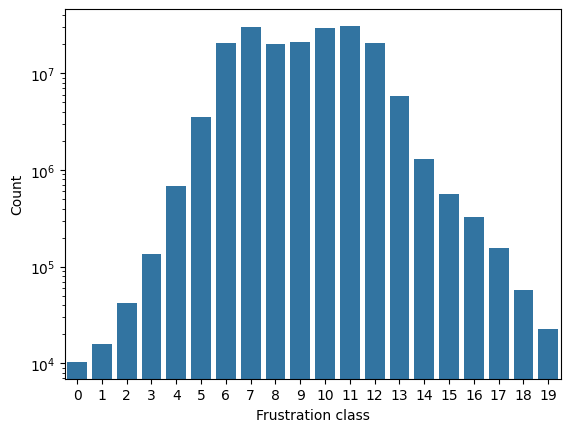

In [25]:
sns.barplot(x=np.arange(len(frst_class_counts)), y=frst_class_counts)
plt.yscale("log")
plt.xlabel("Frustration class")
plt.ylabel("Count")

<Axes: ylabel='Count'>

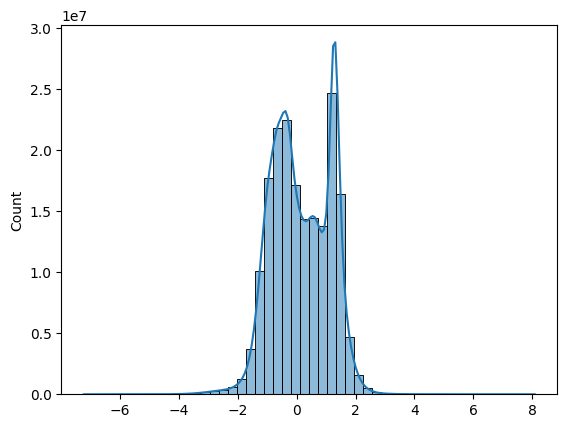

In [15]:
sns.histplot(frst_vals, bins=50, kde=True,)

In [5]:
data_module = FrustrationDataModule(parquet_path=parquet_path, batch_size=2, num_workers=1, persistent_workers=True)

In [6]:
model = FrustrationFNN(input_dim=1024, hidden_dim=32, output_dim=1, dropout=0.15, max_seq_length=500, pLM_model="../data/ProstT5", pLM_precision="full", prefix_prostT5="<AA2fold>")

In [7]:
trainer = Trainer(accelerator='auto',
                    #distributed_backend='ddp',
                    max_epochs=5,
                    #logger=logger,
                    #callbacks=callbacks,
                    gradient_clip_val=1,
                    enable_progress_bar=True,
                    deterministic=True
                    )

trainer.fit(model, datamodule=data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded 982852 samples from ../data/frustration/v3_frustration.parquet.gzip
Created train/val/test masks
Initialized res_idx_mask and frst_vals tensors
Populated res_idx_mask and frst_vals tensors
Created train dataset
Created val dataset
Created test dataset
Train/Val/Test split: 896034/29926/56892 samples



  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | encoder | T5EncoderModel | 1.2 B  | eval 
1 | FNN     | Sequential     | 32.8 K | train
---------------------------------------------------
1.2 B     Trainable params
0         Non-trainable params
1.2 B     Total params
4,832.789 Total estimated model params size (MB)
5         Modules in train mode
439       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 439 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0:   0%|          | 14/448017 [04:58<2652:55:15,  0.05it/s, v_num=17]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
data_module.setup()
for batch in data_module.val_dataloader():
    full_seq, res_mask, frst_vals = batch
    break

Loaded 982852 samples from ../data/frustration/v3_frustration.parquet.gzip
Train/Val/Test split: 896034/29926/56892 samples


In [7]:
full_seq

('MIDQIKRHGLFDIDIHCDGDLEIDDHHTVEDCGITLGQAFAQALGDKKGLRRYGHFYAPLDEALSRVVVDLSGRPGLFMDIPFTRARIGTFDVDLFSEFFQGFVNHALMTLHIDNLKGKNSHHQIESVFKALARALRMACEIDPRAENTIASTKGSL',)

In [20]:
eg_seq = ("SEQVE",)

In [41]:
seq = ["<AA2fold>" + " " + " ".join(seq) for seq in eg_seq]
seq

['<AA2fold> S E Q V E']

In [42]:
tokenizer = T5Tokenizer.from_pretrained("../data/prostT5", do_lower_case=False, max_length=10)
ids = tokenizer.batch_encode_plus(seq, 
                                add_special_tokens=True, 
                                padding="max_length",
                                truncation="longest_first", 
                                max_length=10,
                                return_tensors='pt'
                                )

In [43]:
ids["input_ids"]

tensor([[149,   7,   9,  16,   6,   9,   1,   0,   0,   0]])

In [ ]:
data_module.setup()

Loaded 982852 samples from ../data/frustration/v3_frustration.parquet.gzip


In [ ]:
for batch in tqdm.tqdm(data_module.val_dataloader()):
    #print(batch)
    print(len(batch[0]), batch[1].shape, batch[2].shape)
    break

  0%|          | 0/29926 [00:02<?, ?it/s]

1 torch.Size([1, 2753]) torch.Size([1, 2753])


In [ ]:
df["full_seq"].str.len().max()

np.int64(2753)